# Prediction of the temperature in Berlin, GER.

It was one of my first projects in Machine Learning. The dataset include the meteorological information from Berlin from the period between 1948 until 2019.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
pd.options.display.width = 0
pd.options.display.max_rows = None

## Reading and preparing data.

Let's read the data first and choose the most interesting features.

In [2]:
data = pd.read_csv('berlin_klima_1948_2019_en.txt', sep=';')
less_columns = ["Station_ID", "QN_3", "QN_4", "VPM", "eor", "Average_air_pressure", "Medium_Wind_Speed",
                "Precipitation_form", "Means_of_coverage", "Daily_mean_temp", "Daily_min_temp_ground"]
data.drop(less_columns, inplace=True, axis=1)

In [3]:
print(data.info())
print(data[10700:10800])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 8 columns):
Measurement_date       26298 non-null int64
Max_Wind_Speed         26298 non-null float64
Precipitation_level    26298 non-null float64
Daily_sum_sunshine     26298 non-null float64
Daily_snow_depth       26298 non-null int64
Daily_mean_humidity    26298 non-null float64
Daily_max_temp         26298 non-null float64
Daily_min_temp         26298 non-null float64
dtypes: float64(6), int64(2)
memory usage: 1.6 MB
None
       Measurement_date  Max_Wind_Speed  Precipitation_level  \
10700          19770418            20.1                  0.0   
10701          19770419            14.4                  0.0   
10702          19770420            11.3                  0.0   
10703          19770421            13.4                  5.9   
10704          19770422            19.6                  0.8   
10705          19770423            19.6                  5.9   
10706          19770424  

In [4]:
data = data.replace(-999.0, np.nan)
data = data.replace(-999, np.nan)
# data.fillna(data.median(), inplace=True)
# data = data[data['Measurement_date'] >= 19740101]
data.reset_index(inplace=True)
data = data.drop(['index'], axis=1)

In [5]:
print(data.info())
print(data[12700:12800])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 8 columns):
Measurement_date       26298 non-null int64
Max_Wind_Speed         16716 non-null float64
Precipitation_level    26296 non-null float64
Daily_sum_sunshine     17941 non-null float64
Daily_snow_depth       22221 non-null float64
Daily_mean_humidity    26258 non-null float64
Daily_max_temp         26298 non-null float64
Daily_min_temp         26298 non-null float64
dtypes: float64(7), int64(1)
memory usage: 1.6 MB
None
       Measurement_date  Max_Wind_Speed  Precipitation_level  \
12700          19821009             8.8                  0.0   
12701          19821010             6.2                  0.0   
12702          19821011             7.2                  0.6   
12703          19821012            12.9                  3.1   
12704          19821013            11.8                  6.4   
12705          19821014            14.9                  2.0   
12706          19821015

In [6]:
pd.set_option('use_inf_as_na', True)
data = data.replace([np.inf, -np.inf], 0).dropna(subset=data.columns, how="all")

In [7]:
print(data.info())
print(data[12700:12800])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26298 entries, 0 to 26297
Data columns (total 8 columns):
Measurement_date       26298 non-null int64
Max_Wind_Speed         26298 non-null float64
Precipitation_level    26298 non-null float64
Daily_sum_sunshine     26298 non-null float64
Daily_snow_depth       26298 non-null float64
Daily_mean_humidity    26298 non-null float64
Daily_max_temp         26298 non-null float64
Daily_min_temp         26298 non-null float64
dtypes: float64(7), int64(1)
memory usage: 1.8 MB
None
       Measurement_date  Max_Wind_Speed  Precipitation_level  \
12700          19821009             8.8                  0.0   
12701          19821010             6.2                  0.0   
12702          19821011             7.2                  0.6   
12703          19821012            12.9                  3.1   
12704          19821013            11.8                  6.4   
12705          19821014            14.9                  2.0   
12706          19821015

## Splitting and scalling data.

Beacause it is a continous data we I will split it by hand. To scale the data I will use MinMaxScaler.

In [9]:
predict = "Daily_max_temp"

X = np.array(data.drop([predict], axis=1))
y = np.array(data[predict])

In [10]:
'''SPLITTING FOR TIME SERIES'''
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

For cross validation I will use TimeSeriesSplit().

In [11]:
tscv = TimeSeriesSplit(n_splits=10)

## Machine Learning Models.

* LINEAR REGRESSION

In [12]:
'''LINEAR REGRESSION'''
def lin_reg():
    linear = linear_model.LinearRegression()
    linear.fit(X_train_scaled, y_train)

    print("\n\tCross validation for Linear Regression:")
    lin_reg_scores = cross_val_score(linear, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=tscv)
    lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)
    display_scores(lin_reg_rmse_scores)

    predictions = linear.predict(X_test_scaled) # Gets a list of all predictions
    predictions_train = linear.predict(X_train_scaled)

    score_r2_lin = r2_score(y_test, predictions)
    print("\nR2 of Linear Regression test:\n", score_r2_lin)

    lin_mse = mean_squared_error(y_test, predictions)
    lin_rmse = np.sqrt(lin_mse)
    print("\nMSE of Linear Regression model:\n", lin_mse)
    print("\nRMSE of Linear Regression model:\n", lin_rmse)

    return predictions, predictions_train

* POLYNOMIAL FEATURES

In [13]:
'''POLYNOMIAL FEATURES'''
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
scaler.fit(X_train_poly)
# scaler.fit(X_test_poly)
X_train_poly_scaled = scaler.transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

* POLYNOMIAL REGRESSION

In [14]:
'''POLYNOMIAL FEATURES WITH LINEAR REGRESSION (POLYNOMIAL REGRESSION)'''
def poly_reg():
    linear = linear_model.LinearRegression()
    linear.fit(X_train_poly, y_train)

    print("\n\tCross validation for Polynomial Regression:")
    poly_reg_scores = cross_val_score(linear, X_train_poly, y_train, scoring="neg_mean_squared_error", cv=tscv)
    poly_reg_rmse_scores = np.sqrt(-poly_reg_scores)
    display_scores(poly_reg_rmse_scores)

    predictions = linear.predict(X_test_poly)
    predictions_train = linear.predict(X_train_poly)

    score_r2_poly = r2_score(y_test, predictions)
    print("\nR2 of Polynomial Regression test:\n", score_r2_poly)

    lin_mse_poly = mean_squared_error(y_test, predictions)
    lin_rmse_poly = np.sqrt(lin_mse_poly)
    print("\nMSE of Polynomial Regression model:\n", lin_mse_poly)
    print("\nRMSE of Polynomial Regression model:\n", lin_rmse_poly)

    return predictions, predictions_train

* RIDGE REGRESSION

In [15]:
'''RIDGE REGRESSION'''
def ridge_reg():
    linear_ridge = linear_model.Ridge()
    linear_ridge.fit(X_train_scaled, y_train)

    print("\n\tCross validation for Ridge Regression:")
    ridge_reg_scores = cross_val_score(linear_ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=tscv)
    ridge_reg_rmse_scores = np.sqrt(-ridge_reg_scores)
    display_scores(ridge_reg_rmse_scores)

    predictions = linear_ridge.predict(X_test_scaled)
    predictions_train = linear_ridge.predict(X_train_scaled)

    score_r2_ridge = r2_score(y_test, predictions)
    print("\nR2 of Ridge Regression test:\n", score_r2_ridge)

    lin_mse_ridge = mean_squared_error(y_test, predictions)
    lin_rmse_ridge = np.sqrt(lin_mse_ridge)
    print("\nMSE of Ridge Regression model:\n", lin_mse_ridge)
    print("\nRMSE of Ridge Regression model:\n", lin_rmse_ridge)
    return predictions, predictions_train

* RIDGE REGRESSION WITH POLYNOMIAL FEATURES

In [16]:
'''RIDGE REGRESSION WITH POLYNOMIAL FEATURES'''
def ridge_reg_poly():
    linear_ridge_poly = linear_model.Ridge()
    linear_ridge_poly.fit(X_train_poly_scaled, y_train)

    print("\n\tCross validation for Polynomial Ridge Regression:")
    poly_ridge_reg_scores = cross_val_score(linear_ridge_poly, X_train_poly_scaled, y_train,
                                            scoring="neg_mean_squared_error", cv=tscv)
    poly_ridge_reg_rmse_scores = np.sqrt(-poly_ridge_reg_scores)
    display_scores(poly_ridge_reg_rmse_scores)

    predictions = linear_ridge_poly.predict(X_test_poly_scaled)
    predictions_train = linear_ridge_poly.predict(X_train_poly_scaled)

    score_r2_ridge_poly = r2_score(y_test, predictions)
    print("\nR2 of Polynomial Ridge Regression test:\n", score_r2_ridge_poly)

    lin_mse_ridge_poly = mean_squared_error(y_test, predictions)
    lin_rmse_ridge_poly = np.sqrt(lin_mse_ridge_poly)
    print("\nMSE of Polynomial Ridge Regression model:\n", lin_mse_ridge_poly)
    print("\nRMSE of Polynomial Ridge Regression model:\n", lin_rmse_ridge_poly)
    return predictions, predictions_train

* RANDOM FOREST

In [17]:
'''RANDOM FOREST'''
def rand_forests():
    forest = RandomForestRegressor(n_jobs=-1, random_state=42)
    forest.fit(X_train, y_train)

    print("\n\tCross validation for Random Forest:")
    forest_scores = cross_val_score(forest, X_train, y_train, scoring="neg_mean_squared_error", cv=tscv)
    forest_rmse_scores = np.sqrt(-forest_scores)
    display_scores(forest_rmse_scores)

    predictions = forest.predict(X_test)
    predictions_train = forest.predict(X_train)

    score_r2_forest = r2_score(y_test, predictions)
    print("\nR2 of Random Forest test:\n", score_r2_forest)

    mse_random_forest = mean_squared_error(y_test, predictions)
    rmse_random_forest = np.sqrt(mse_random_forest)
    print("\nMSE of Random Forest model:\n", mse_random_forest)
    print("\nRMSE of Random Forest model:\n", rmse_random_forest)

    feature_names = list(data)
    print(sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), feature_names),
                reverse=True))

    return predictions, predictions_train

* GRADIENT BOOST REGRESSOR FOR RANDOM FOREST WITH EARLY STOPPING

In [18]:
'''GRADIENT BOOST REGRESSOR FOR RANDOM FOREST WITH EARLY STOPPING'''
def gbrt_1():
    gbrt = GradientBoostingRegressor(learning_rate=0.1)
    gbrt.fit(X_train, y_train)

    errors = [mean_squared_error(y_test, y_pred)
                for y_pred in gbrt.staged_predict(X_test)]
    bst_n_estimators = np.argmin(errors)

    gbrt_best = GradientBoostingRegressor(n_estimators=bst_n_estimators)
    gbrt_best.fit(X_train, y_train)

    print("\n\tCross validation for Gradient Boost Regressor:")
    gbrt_scores = cross_val_score(gbrt_best, X_train, y_train, scoring="neg_mean_squared_error", cv=tscv)
    gbrt_rmse_scores = np.sqrt(-gbrt_scores)
    display_scores(gbrt_rmse_scores)

    predictions = gbrt_best.predict(X_test)
    predictions_train = gbrt.predict(X_train)

    score_r2_gbrt_1 = r2_score(y_test, predictions)
    print("\nR2 of Random Gradient Boost Regressor test:\n", score_r2_gbrt_1)

    mse_gbrt = mean_squared_error(y_test, predictions)
    rmse_gbrt = np.sqrt(mse_gbrt)
    print("\nMSE of Gradient Boosting Reg with Early Stopping model:\n", mse_gbrt)
    print("\nRMSE of Gradient Boosting Reg with Early Stopping model:\n", rmse_gbrt)
    return predictions, predictions_train

In [19]:
'''GBR WITH IMPLEMENTATION EARLY STOPPING BY REAL STOPPING EARLY'''
def gbrt_2():
    # gbrt = gbrt_1()
    def gbrt_2_estimators():
        gbrt_warm = GradientBoostingRegressor(warm_start=True)
        min_val_error = float("inf")
        error_going_up = 0
        for n_estimators in range(1, 210):
            gbrt_warm.n_estimators = n_estimators
            gbrt_warm.fit(X_train, y_train)
            predictions = gbrt_warm.predict(X_test)
            predictions_train = gbrt_warm.predict(X_train)
            val_error = mean_squared_error(y_test, predictions)
            if val_error < min_val_error:
                min_val_error = val_error
                error_going_up = 0
            else:
                error_going_up += 1
                if error_going_up == 5:
                    break # early stopping
            return gbrt_warm, min_val_error, predictions, predictions_train

    gbrt_warm, min_val_error, predictions, predictions_train = gbrt_2_estimators()

    score_r2_gbrt_2 = r2_score(y_test, predictions)
    print("\nR2 of real early warm=true stop Gradient Boost Regressor test:\n", score_r2_gbrt_2)

    print("\n\tCross validation for real early warm=true stop Gradient Boost Regressor:")
    gbrt_warm_scores = cross_val_score(gbrt_warm, X_train, y_train, scoring="neg_mean_squared_error", cv=tscv)
    gbrt_warm_rmse_scores = np.sqrt(-gbrt_warm_scores)
    display_scores(gbrt_warm_rmse_scores)

    rmse_gbrt_best = np.sqrt(min_val_error)
    print("\nMSE of Gradient Boosting Reg with warm start:\n", min_val_error)
    print("\nRMSE of Gradient Boosting Reg with warm start:\n", rmse_gbrt_best)
    print("\nHow many estimators:\n", gbrt_warm.n_estimators)

    return predictions, predictions_train
    # return predictions, predictions_train

* EXTREME GRADIENT BOOSTING

In [20]:
'''EXTREME GRADIENT BOOSTING'''
def xgb():
    xgb_reg = xgboost.XGBRegressor()
    xgb_reg.fit(X_train, y_train)

    print("\n\tCross validation for Extreme Gradient Boosting:")
    xgb_scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=tscv)
    xgb_rmse_scores = np.sqrt(-xgb_scores)
    display_scores(xgb_rmse_scores)

    predictions = xgb_reg.predict(X_test)
    predictions_train = xgb_reg.predict(X_train)

    mse_xgb = mean_squared_error(y_test, predictions)
    rmse_xgb = np.sqrt(mse_xgb)
    print("\nMSE of Extreme Gradient Boosting Reg model:\n", mse_xgb)
    print("\nRMSE of Extreme Gradient Boosting Reg model:\n", rmse_xgb, "\n")

    xgb_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10)
    predictions = xgb_reg.predict(X_test)
    return predictions, predictions_train

In [21]:
'''EVALUATION WITH CROSS-VALIDATION'''
def display_scores(scores):
    print("\nScores:\n", scores)
    print("Mean:\n", scores.mean())
    print("Standard deviation:\n", scores.std())


	Cross validation for Linear Regression:

Scores:
 [2.69014802 2.85776279 2.41132115 2.37598251 2.42985339 2.29297009
 2.15743709 2.20029233 2.13725814 2.26922508]
Mean:
 2.3822250588544547
Standard deviation:
 0.22101585344493974

R2 of Linear Regression test:
 0.9263779505581495

MSE of Linear Regression model:
 6.103097361529968

RMSE of Linear Regression model:
 2.470444769981707


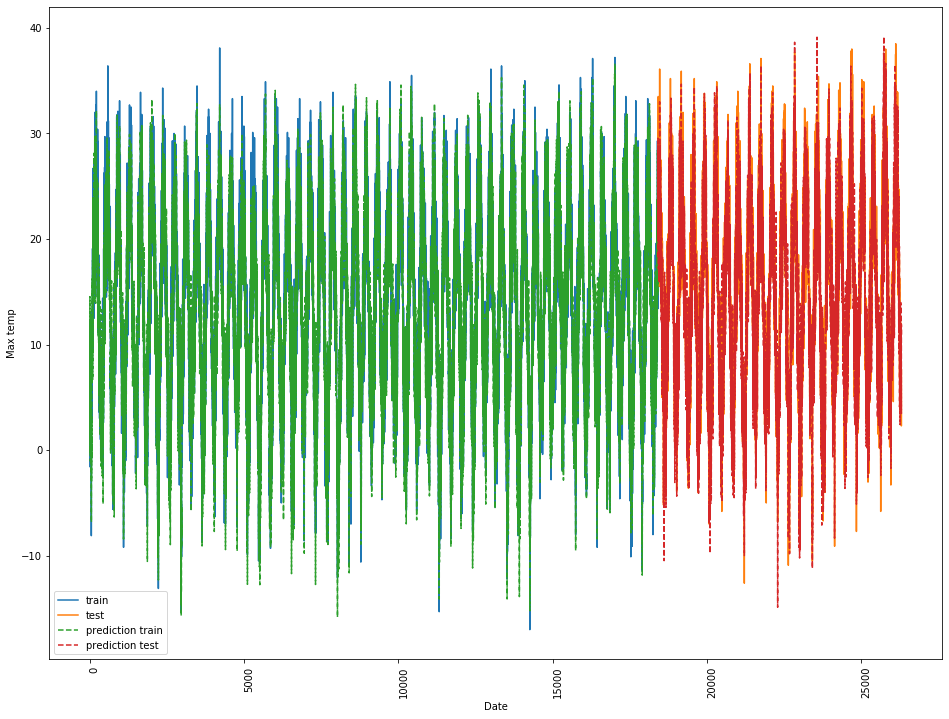

In [27]:
'''Lets try to plot some predictions'''
predictions, predictions_train = lin_reg()

n_train = (len(data['Measurement_date'])) * 0.7
n_train = int(n_train)
# print(n_train)

plt.figure(figsize=(16, 12))
plt.xticks(rotation=90, ha="left")
plt.plot(range(n_train), y_train, label="train")
plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
plt.plot(range(n_train), predictions_train, '--', label="prediction train")
plt.plot(range(n_train, len(y_test) + n_train), predictions, '--', label="prediction test")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Max temp")
plt.show()